# Object detection

In [5]:
# !mim download mmdet --config mask-rcnn_swin-t-p4-w7_fpn_1x_coco --dest .
%load_ext autoreload
%autoreload 2

from PIL import Image
import torch

from mmdet.apis import init_detector, inference_detector
from mmengine.config import Config
from cfm_task_models.legacy import *

from cfm_task_models.split_models import SplitTwoStageDetector, TwoInputIdentity, SplitRepPointsV2MaskDetector
from cfg_task_models.split_backbones import SplitSwinTransformer

config_file_old = 'obj_det/cfgs/swin_tiny_mask_rcnn_simplified_cfg.py'
checkpoint_file_old = 'obj_det/chkpts/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth'
config_file = 'obj_det/cfgs/mask_reppointsv2_swin_t_modified.py'
checkpoint_file = 'obj_det/chkpts/mask_reppointsv2_swin_tiny_patch4_window7_3x.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model_init = init_detector(config_file, checkpoint_file, device='cpu')  # or device='cuda:0'
# result = inference_detector(model, 'demo/demo.jpg')

# from mmdet.registry import MODELS
# MODELS.get('SwinTransformer')
# MODELS.get('TwoStageDetector')
model = SplitRepPointsV2MaskDetector.create_from_cfg_and_checkpoint(config_file, checkpoint_file).to(device)
# model2 = SplitTwoStageDetector.create_from_cfg_and_checkpoint(config_file_old,checkpoint_file_old).to(device)
# model.frontend_preprocessor
model.cut_point

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
04/02 13:57:13 - mmengine - INFO - Loads checkpoint by local backend from path: obj_det/chkpts/mask_reppointsv2_swin_tiny_patch4_window7_3x.pth


/localhome/aharell/.pyenv/versions/3.9.5/lib/python3.9/subprocess.py:1052: ResourceWarning: subprocess 421 is still running
  _warn("subprocess %s is still running" % self.pid,


Done!!, save to obj_det/chkpts/mask_reppointsv2_swin_tiny_patch4_window7_3x_converted-dd7afe98.pth


/local-scratch2/aharell/CFM-Task-Models/.venv/lib/python3.9/site-packages/mmdet/models/task_modules/builder.py:39: UserWarning: ``build_assigner`` would be deprecated soon, please use ``mmdet.registry.TASK_UTILS.build()`` 
  warnings.warn('``build_assigner`` would be deprecated soon, please use '
/local-scratch2/aharell/CFM-Task-Models/.venv/lib/python3.9/site-packages/mmdet/models/task_modules/builder.py:24: UserWarning: ``build_iou_calculator`` would be deprecated soon, please use ``mmdet.registry.TASK_UTILS.build()`` 
  warnings.warn(
/local-scratch2/aharell/CFM-Task-Models/.venv/lib/python3.9/site-packages/mmdet/models/task_modules/builder.py:46: UserWarning: ``build_sampler`` would be deprecated soon, please use ``mmdet.registry.TASK_UTILS.build()`` 
  warnings.warn('``build_sampler`` would be deprecated soon, please use '
/local-scratch2/aharell/CFM-Task-Models/.venv/lib/python3.9/site-packages/mmdet/apis/inference.py:90: UserWarning: dataset_meta or class names are not saved in 

Loads checkpoint by local backend from path: obj_det/chkpts/mask_reppointsv2_swin_tiny_patch4_window7_3x_converted-dd7afe98.pth


/local-scratch2/aharell/CFM-Task-Models/.venv/lib/python3.9/site-packages/mmdet/models/task_modules/builder.py:39: UserWarning: ``build_assigner`` would be deprecated soon, please use ``mmdet.registry.TASK_UTILS.build()`` 
  warnings.warn('``build_assigner`` would be deprecated soon, please use '
/local-scratch2/aharell/CFM-Task-Models/.venv/lib/python3.9/site-packages/mmdet/models/task_modules/builder.py:24: UserWarning: ``build_iou_calculator`` would be deprecated soon, please use ``mmdet.registry.TASK_UTILS.build()`` 
  warnings.warn(
/local-scratch2/aharell/CFM-Task-Models/.venv/lib/python3.9/site-packages/mmdet/models/task_modules/builder.py:46: UserWarning: ``build_sampler`` would be deprecated soon, please use ``mmdet.registry.TASK_UTILS.build()`` 
  warnings.warn('``build_sampler`` would be deprecated soon, please use '


1

In [2]:
from mmengine.runner import Runner
from mmdet.structures import DetDataSample
from typing import Union
from torch import Tensor
def to_device(data_sample:Union[dict,Tensor], device):
    if isinstance(data_sample,dict):
        for k,v in data_sample.items():
            if isinstance(v, (Tensor, DetDataSample)):
                data_sample[k] = v.to(device)
                # print(f'{k} was sent to {device}')
            elif isinstance(v, list):
                new_v = [to_device(v2, device) for v2 in v]
                data_sample[k] = new_v
                # print(f'components of {k} were sent to {device}')
            else:
                print(f'{k} could not be sent to {device}')
    elif isinstance(data_sample, (Tensor, DetDataSample)):
        data_sample = data_sample.to(device)
        # print(f'input was sent to {device}')
    elif isinstance(data_sample, list):
        data_sample = [to_device(v, device) for v in data_sample]
        # print(f'components of input were sent to {device}')
    else:
        # print(type(data_sample))
        print(f'input could not be sent to {device}')
    return data_sample


In [3]:


cfg_tr = model.cfg.copy()
print(cfg_tr['train_dataloader']['dataset']['ann_file'])
cfg_tr['train_dataloader']['batch_size'] = 8
cfg_tr['train_dataloader']['num_workers'] = 1

train_dataloader = Runner.build_dataloader(cfg_tr['train_dataloader']) 

print(cfg_tr['val_dataloader']['dataset']['ann_file'])
val_dataloader = Runner.build_dataloader(cfg_tr['val_dataloader'])

test_dataloader = Runner.build_dataloader(cfg_tr['test_dataloader'])
print(len(val_dataloader.dataset))

/local-scratch2/aharell/CFM-Task-Models/data/coco/annotations/coco2017_trn_split_anns.json
loading annotations into memory...
Done (t=12.41s)
creating index...
index created!
/local-scratch2/aharell/CFM-Task-Models/data/coco/annotations/coco2017_val_split_anns.json
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
5915


In [4]:
# dl = runner.train_dataloader
# print(model.cut_point)
# val_eval = Runner.build_evaluator(_,cfg_tr['val_evaluator'])
# setattr(val_eval,'dataset_meta',val_dataloader.dataset.metainfo)
from copy import deepcopy
test_evaluator_cfg = deepcopy(cfg_tr['test_evaluator'])
print(cfg_tr['train_dataloader']['dataset']['data_root'],cfg_tr['test_dataloader']['dataset']['ann_file'] )
test_evaluator_cfg['ann_file'] = os.path.join(cfg_tr['test_dataloader']['dataset']['data_root'], test_evaluator_cfg['ann_file'])
# # print(test_evaluator_cfg)
test_eval = Runner.build_evaluator(_,cfg_tr['test_evaluator'])
setattr(test_eval,'dataset_meta',test_dataloader.dataset.metainfo)
# print(val_eval.dataset_meta)
for i,data in enumerate(train_dataloader):
    model.train()
    model.zero_grad()

    # data =  to_device(data,device)
    # feat = model2.feature_frontend(data)
    # print(feat['inputs']['outs'][0].shape)
    # out2 = model2.test_step(feat)
    # print(data['data_samples'][0])
    if isinstance(model, SplitRepPointsV2MaskDetector):
        if 'scale_factor' in data['data_samples'][0]:
            for d in data['data_samples']:
                meta = d.metainfo 
                # print(d)
                meta['scale_factor'] = d.scale_factor * (2 if len(meta['scale_factor']) == 2 else 1)
                d.set_metainfo(meta)

    # im['inputs'] = torch.stack(im['inputs'])
    # print(list(data_.keys()))
    # data_ = train_pipeline(im)
    # data_ = prp(data_, False)
    # data_['inputs'] = model.backbone.split_forward_v2(data_['inputs'], output_layer=model.cut_point-1)
    # data_['inputs'] = {
    #                "hw_shape": data_['inputs'][0],
    #
    #                "outs": data_['inputs'][1]}
    # data = prp(data, False)

    
    feat = model.feature_frontend(data)
    print(feat)
    # print(feat['inputs']['outs'][0].shape)
    loss = model.backend_loss(feat)
    break
    # out = model.test_step(feat)
    # props = model.backend_raw(feat)
    # print(model.cut_point)
    # print(model.test_step(feat)[0])
    # losses = model.loss(data_['inputs'], data_['data_samples'])
    # loss, losses = model.parse_losses(losses)
    # test_eval.process(out)
# print(out[0].pred_instances.masks)
# test_eval.evaluate(i+1)


# for i,data in enumerate(test_dataloader):
#     model.eval()
#     model.zero_grad()
#     with torch.no_grad():
    
#         # data =  to_device(data,device)
#         # feat = model2.feature_frontend(data)
#         # print(feat['inputs']['outs'][0].shape)
#         # out2 = model2.test_step(feat)
#         if isinstance(model, SplitRepPointsV2MaskDetector):
#             for d in data['data_samples']:
#                 meta = d.metainfo 
#                 meta['scale_factor'] = d.scale_factor * (2 if len(meta['scale_factor']) == 2 else 1)
#                 d.set_metainfo(meta)

#         # im['inputs'] = torch.stack(im['inputs'])
#         # print(list(data_.keys()))
#         # data_ = train_pipeline(im)
#         # data_ = prp(data_, False)
#         # data_['inputs'] = model.backbone.split_forward_v2(data_['inputs'], output_layer=model.cut_point-1)
#         # data_['inputs'] = {
#         #                "hw_shape": data_['inputs'][0],
#         #
#         #                "outs": data_['inputs'][1]}
#         # data = prp(data, False)

        
#         feat = model.feature_frontend(data)
#         # print(feat['inputs']['outs'][0].shape)
#         out = model.test_step(feat)
#         # props = model.backend_raw(feat)
#         # print(model.cut_point)
#         # print(model.test_step(feat)[0])
#         # losses = model.loss(data_['inputs'], data_['data_samples'])
#         # loss, losses = model.parse_losses(losses)
#         test_eval.process(out)
# # print(out[0].pred_instances.masks)
# test_eval.evaluate(i+1)

/local-scratch2/aharell/CFM-Task-Models/data/coco/ annotations/instances_val2017.json
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
{'inputs': {'hw_shape': (64, 64), 'outs': [tensor([[[ 0.5074, -0.4767,  0.2111,  ..., -1.1294, -0.5463, -0.4733],
         [ 0.3800, -0.7736, -0.8083,  ..., -0.9574, -0.4965,  0.6155],
         [ 0.9841, -0.6307, -1.7346,  ..., -1.1287, -0.5859, -1.5732],
         ...,
         [ 0.1261,  1.5027, -1.0529,  ..., -1.1411, -1.5647, -0.4083],
         [ 0.5352, -0.3506, -0.6773,  ..., -0.7424, -0.4683, -0.0187],
         [ 0.4994, -0.3575,  0.6478,  ...,  0.4324,  0.2575,  0.2238]],

        [[ 1.1191, -0.0262,  0.1246,  ..., -0.5697, -0.0589, -0.4519],
         [ 0.6918, -0.6183,  0.3391,  ...,  0.0117,  0.2673, -0.8356],
         [-0.7709, -0.7283, -0.4813,  ..., -1.2024,  1.0074,  1.3053],
         ...,
         [-0.3122,  1.3874, -0.3104,  ..., -0.9777,  0.5686, -0.1810],
         [-0.2019,  1.3068, -0.4185,  ..., -0.98

/local-scratch2/aharell/CFM-Task-Models/.venv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
torch.int

NameError: name 'torch' is not defined

In [ ]:
val_eval = Runner.build_evaluator(_,cfg_tr['val_evaluator'])
setattr(val_eval,'dataset_meta',val_dataloader.dataset.metainfo)

# test_evaluator_cfg = deepcopy(cfg_tr['test_evaluator'])
# print(train_dataset_cfg['data_root'],cfg_tr['test_dataloader']['dataset']['ann_file'] )
# test_evaluator_cfg['ann_file'] = os.path.join(cfg_tr['test_dataloader']['dataset']['data_root'], test_evaluator_cfg['ann_file'])
# print(test_evaluator_cfg)
test_eval = Runner.build_evaluator(_,cfg_tr['test_evaluator'])
setattr(test_eval,'dataset_meta',test_dataloader.dataset.metainfo)
# print(val_eval.dataset_meta)
# print(out)
test_eval.process(out)
test_eval.evaluate(1)
print(test_eval.metrics[0].results)

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
loading annotations into memory...
Done (t=1.62s)
creating index...
index created!
03/29 14:51:19 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.81s).
Accumulating evaluation results...
DONE (t=1.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Av

In [ ]:
a = Instances()

fk = torch.Tensor([[[3,4]],[[4,5]],[[5,6]]])
device = 'cuda'
a.fpn_levels = torch.cat([torch.tensor([i]*r[:,0].numel()).to(device) for i,r in enumerate(fk)])

(array([[  0.,   0.,   1., ...,  34.,   0.,   0.],
        [  0.,   0.,   0., ...,  91.,   2.,   0.],
        [  0.,   0.,   0., ...,  47.,   0.,   0.],
        ...,
        [  5.,  92.,  22., ...,  41.,   5.,   0.],
        [  0.,   0.,   0., ...,  57.,   4.,   0.],
        [  0.,   0.,   0., ..., 122.,   1.,   0.]]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <a list of 2850 BarContainer objects>)

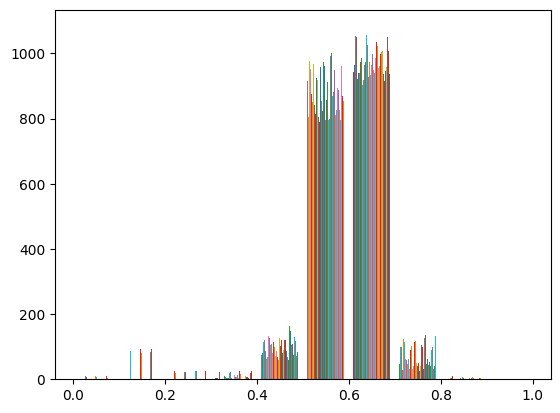

In [ ]:
from matplotlib import pyplot as plt
mx = feat['inputs']['outs'][0][0,:].max().item()
mn = feat['inputs']['outs'][0][0,:].min().item()
f_np = feat['inputs']['outs'][0][0,:].reshape(2048,-1).cpu().detach()
f_np = f_np.detach().numpy()
# print(f_np)
plt.hist((f_np-mn)/(mx-mn))

In [ ]:
# feat2 = feat['inputs']['outs'][0].view(-1, *feat['inputs']['hw_shape'],
#                                 model.backbone.num_features[0]).permute(0, 3, 1,
#                                                                 2).contiguous()
# print(feat2.shape)
norm0 = getattr(model.backbone, 'norm0')
feats_to_comp  = norm0( feat['inputs']['outs'][0]).view(-1, *feat['inputs']['hw_shape'],
                                model.backbone.num_features[0]).permute(0, 3, 1,
                                                                2).contiguous()
print(feats_to_comp.shape)

AttributeError: 'SplitSwinTransformer' object has no attribute 'norm0'

In [ ]:
for data in vdl:
    # model.cut_point = 0
    # model.data_preprocessor = model.frontend_preprocessor
    # print(model.val_step(data))
    # model.cut_point = 1
    # model.data_preprocessor = TwoInputIdentity()
    data_ = model.frontend_preprocessor(data, False)
    print(data_['data_samples'])
    break
    data_['inputs'] = model.backbone.split_forward_v2(data_['inputs'], output_layer=model.cut_point-1)
    data_['inputs'] = {#"x": data_['inputs'][0],
                    "hw_shape": data_['inputs'][0],
                    "outs": data_['inputs'][1]}
    print(len(data_['inputs']['outs']))
    print(data_)
    # data_['inputs'] = [data_['inputs']]
    # data_['data_samples'] = [data_['data_samples']]
    # # forward the model
    with torch.no_grad():
        results = model.backend_inference(data_)[0]
    break

In [ ]:
vdl = runner.val_dataloader

In [ ]:
model.backbone.stages[0]

In [ ]:
from numpy import log2 as log
def H(d):
    return -d*log(d) + (d-1)*log(1-d)

m = 8
D = np.linspace(0.1442,0.14421,10000000)
# R = 1-D*m/(m-1)
# rate = R*log(m)
the_rate = log(m) -H(D) - D * log(m-1) - 2
print(D[np.where(the_rate < 0)[0][0]])
the_rate[np.where(the_rate < 0)[0][0]] + 2

0.1442085560638556


1.999999999998509